In [ ]:
# Install required libraries
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers datasets sklearn networkx tensorflow_federated
!pip install torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 7.4 MB/s e

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [ ]:
# Uninstall torchvision and torchaudio
!pip uninstall -y torchvision torchaudio

# Reinstall torchvision and torchaudio with CUDA 11.8
!pip install torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')



Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.0%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached https://download.pytorch.org/whl/triton-3.3.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.6/955.6 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 93

### Load and Inspect Datase

In [ ]:
# Load your dataset
df = pd.read_csv('/root/Phishing_Email.csv')

# Show basic info
print("Column names:", df.columns.tolist())
df.head()


Column names: ['Unnamed: 0', 'Email Text', 'Email Type']


,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


## Preprocess Data

In [ ]:

df['Email Type'] = df['Email Type'].str.strip().str.lower()

# Check unique values
print("Unique labels:", df['Email Type'].unique())

# Now map to 0 and 1
df['Label'] = df['Email Type'].map({'phishing email': 1, 'safe email': 0})

# Check for missing labels
print("Missing labels:", df['Label'].isna().sum())

# Drop unwanted column
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

# Map labels: 'phishing email' -> 1, 'safe email' -> 0
df['Label'] = df['Email Type'].map({'phishing email': 1, 'safe email': 0})
import re

# Clean the email text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "url", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_text'] = df['Email Text'].apply(clean_text)




Unique labels: ['safe email' 'phishing email']
Missing labels: 0


## Feature Extraction with BERT

In [ ]:
# Load BERT tokenizer


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokens = tokenizer(
    list(df['clean_text']),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

labels = torch.tensor(df['Label'].values)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## BERT-based Classifier

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(768, 2)  # Binary classification

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = output.pooler_output
        return self.fc(self.dropout(cls_output))

# Create model instance
model = BERTClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

## Prepare DataLoader for Training

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

labels = torch.tensor(df['Label'].values)

dataset = TensorDataset(tokens['input_ids'], tokens['attention_mask'], labels)
train_size = int(0.8 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])

train_loader = DataLoader(train_dataset, batch_size=16, sampler=RandomSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=16)


## Train the BERT Model

In [ ]:
# Step 2: Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim

# Step 3: Define model, optimizer, loss

model = BERTClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Step 4: Define checkpoint paths and functions
checkpoint_dir = "/content/drive/MyDrive/colab_checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

def save_checkpoint(model, optimizer, epoch, path=checkpoint_path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)
    print(f"✅ Checkpoint saved at {path}")

def load_checkpoint(model, optimizer, path=checkpoint_path):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device) # Map to device during loading
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # Safely get epoch, default to 0 if key is missing
        start_epoch = checkpoint.get('epoch', 0)
        print(f"🔄 Loaded checkpoint. Resuming from epoch {start_epoch + 1}")
        return start_epoch + 1 # Return the next epoch number
    else:
        print("⚠️ No checkpoint found. Starting from scratch.")
        return 0

# Step 5: Training loop
start_epoch = load_checkpoint(model, optimizer)

# Adjust the loop range based on the desired total number of epochs (e.g., 3 total epochs)
total_epochs = 3
for epoch in range(start_epoch -1, total_epochs): # Start epoch is the *next* epoch number, so subtract 1 for the loop range
    model.train()
    total_loss = 0
    # Check if train_loader is available and not None or empty
    if train_loader is None or len(train_loader) == 0:
        print("❌ train_loader is empty or not defined. Skipping training.")
        break # Exit the training loop if no data

    for batch in train_loader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        optimizer.zero_grad()
        output = model(b_input_ids, b_input_mask)
        loss = criterion(output, b_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Only print and save if training happened in this epoch
    if len(train_loader) > 0:
        print(f"📘 Epoch {epoch+1} | Loss: {total_loss / len(train_loader):.4f}")
        save_checkpoint(model, optimizer, epoch + 1) # Save the epoch that *just finished*




🔄 Loaded checkpoint. Resuming from epoch 1
📘 Epoch 1 | Loss: 0.0331
✅ Checkpoint saved at /content/drive/MyDrive/colab_checkpoints/checkpoint.pth
📘 Epoch 2 | Loss: 0.0277
✅ Checkpoint saved at /content/drive/MyDrive/colab_checkpoints/checkpoint.pth
📘 Epoch 3 | Loss: 0.0243
✅ Checkpoint saved at /content/drive/MyDrive/colab_checkpoints/checkpoint.pth


## Evaluate Model

In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
        outputs = model(b_input_ids, b_input_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2204
           1       0.98      1.00      0.99      1526

    accuracy                           0.99      3730
   macro avg       0.99      0.99      0.99      3730
weighted avg       0.99      0.99      0.99      3730



## Test results and plot graphs


📝 Classification Report:
              precision    recall  f1-score   support

Not Phishing       1.00      0.98      0.99      2204
    Phishing       0.98      1.00      0.99      1526

    accuracy                           0.99      3730
   macro avg       0.99      0.99      0.99      3730
weighted avg       0.99      0.99      0.99      3730



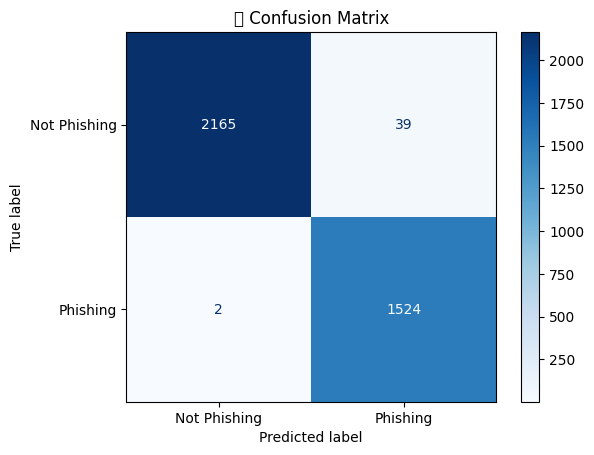

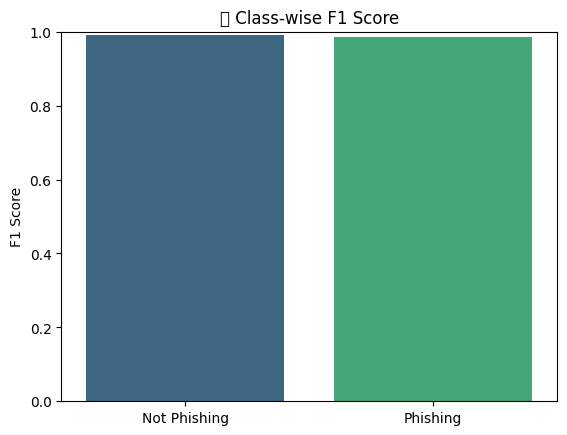


🔍 Sample Predictions:
                                              EmailText  TrueLabel  \
1936  entelligence phase i fyi we need to strategize...          0   
2350  use perl daily headline mailerthis week on per...          0   
2317  wynne conor wrote hi ladies i setup a cron job...          0   
3479  special stream at cognitive society special st...          0   
156   smart shoppers click here for the best rates p...          1   

      PredictedLabel  
1936               0  
2350               0  
2317               0  
3479               0  
156                1  


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure model is in eval mode
model.eval()

# Prepare lists to collect outputs
all_preds = []
all_labels = []
all_texts = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [t.to(device) for t in batch]
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Decode input_ids back to text
        for ids in input_ids.cpu():
            text = tokenizer.decode(ids, skip_special_tokens=True)
            all_texts.append(text)

# === Display classification report ===
print("\n📝 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Not Phishing", "Phishing"]))

# === Plot Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])
disp.plot(cmap='Blues')
plt.title("📊 Confusion Matrix")
plt.show()

# === Plot class-wise accuracy bar chart ===
report_dict = classification_report(all_labels, all_preds, target_names=["Not Phishing", "Phishing"], output_dict=True)
accuracy_per_class = {k: v['f1-score'] for k, v in report_dict.items() if k in ["Not Phishing", "Phishing"]}

sns.barplot(x=list(accuracy_per_class.keys()), y=list(accuracy_per_class.values()), palette="viridis")
plt.ylabel("F1 Score")
plt.title("📈 Class-wise F1 Score")
plt.ylim(0, 1)
plt.show()

# === Display sample predictions ===
sample_df = pd.DataFrame({
    'EmailText': all_texts,
    'TrueLabel': all_labels,
    'PredictedLabel': all_preds
})

print("\n🔍 Sample Predictions:")
print(sample_df.sample(5))


## federated learning

🔄 Loaded checkpoint. Resuming from epoch 11
Current learning rate after loading/initialization: 0.000005

🌐 Round 11/15
🔹 Client 1 training...
🔹 Client 2 training...
🔹 Client 3 training...
Learning rate after round 11: 0.000005
✅ Global Model Accuracy after Round 11: 0.9477 (3 clients participated)
✅ Checkpoint saved at /content/drive/MyDrive/colab_federated_checkpoints/federated_checkpoint_fedavg.pth
💾 Global model checkpoint saved

🌐 Round 12/15
🔹 Client 1 training...
🔹 Client 2 training...
🔹 Client 3 training...
Learning rate after round 12: 0.000005
✅ Global Model Accuracy after Round 12: 0.9566 (3 clients participated)
✅ Checkpoint saved at /content/drive/MyDrive/colab_federated_checkpoints/federated_checkpoint_fedavg.pth
💾 Global model checkpoint saved

🌐 Round 13/15
🔹 Client 1 training...
🔹 Client 2 training...
🔹 Client 3 training...
Learning rate after round 13: 0.000005
✅ Global Model Accuracy after Round 13: 0.9491 (3 clients participated)
✅ Checkpoint saved at /content/drive

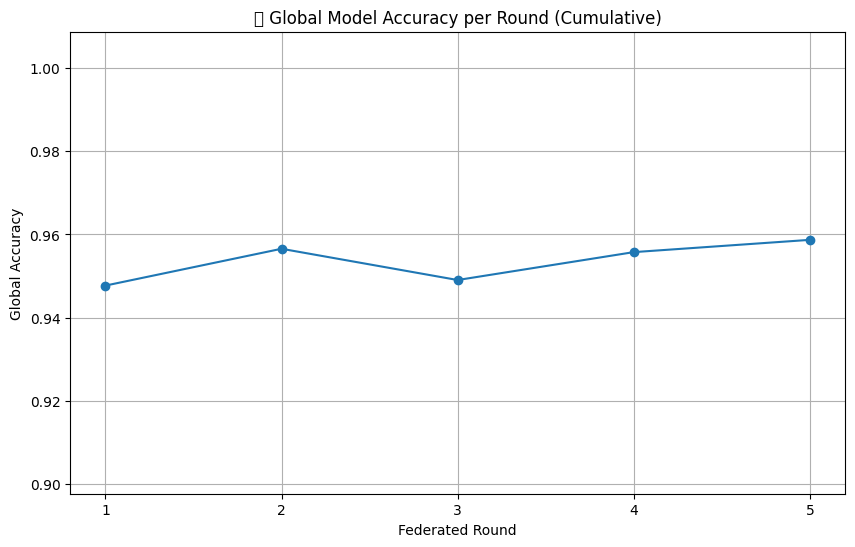

In [ ]:
# %% [markdown]
# ## federated learning
# %%
import torch
import copy
import os
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import accuracy_score
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd # Ensure pandas is imported for isnan check

# === Config ===
NUM_CLIENTS = 3
NUM_ROUNDS = 15 # Optionally increase rounds further
BATCH_SIZE = 8
MAX_BATCHES_PER_CLIENT = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Ensure device is defined globally

# === Load model & checkpoint ===
# Note: The initial 'model' and 'optimizer' defined earlier are used for the standard training loop.
# For federated learning, we'll create a 'global_model' and potentially load its state separately.
# We'll reuse the existing criterion.
criterion = nn.CrossEntropyLoss() # Ensure criterion is defined if not already

# Define a SEPARATE checkpoint path for the federated model
federated_checkpoint_dir = "/content/drive/MyDrive/colab_federated_checkpoints"
federated_checkpoint_path = os.path.join(federated_checkpoint_dir, "federated_checkpoint_fedavg.pth") # More specific name

# Create the federated checkpoint directory if it doesn't exist
os.makedirs(federated_checkpoint_dir, exist_ok=True)


# === Federated utils ===

def get_model_parameters(model):
    """Returns a list of flattened parameters for each layer."""
    params = []
    for param in model.parameters():
        # We only want parameters that require gradients for training
        if param.requires_grad:
            params.append(param.data.view(-1)) # Flatten the tensor
    return torch.cat(params) # Concatenate all flattened parameters into one tensor

def set_model_parameters(model, params):
    """Sets the model's parameters from a flattened tensor."""
    pointer = 0
    for param in model.parameters():
        if param.requires_grad:
            num_param = param.data.numel()
            # Reshape the flattened parameters back to the original shape
            param.data = params[pointer:pointer + num_param].view_as(param.data)
            pointer += num_param

def federated_avg(local_params_list):
    """Computes the federated average of a list of local parameter tensors."""
    if not local_params_list:
        return None

    # Stack all local parameter tensors along a new dimension
    stacked_params = torch.stack(local_params_list)
    # Compute the mean along the stacking dimension
    avg_params = torch.mean(stacked_params, dim=0)
    return avg_params

def train_limited_batches(model, loader, optimizer, criterion, max_batches=MAX_BATCHES_PER_CLIENT):
    """Trains the model for a limited number of batches."""
    model.train()
    total_loss = 0
    batches_processed = 0
    # Add a check to ensure loader is not empty
    if loader is None or len(loader) == 0:
        print("❌ Loader is empty for this client. Skipping training.")
        return 0, 0 # Return zero loss and batches processed if loader is empty

    for batch in loader:
        if batches_processed >= max_batches:
            break # Stop after processing max_batches

        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        optimizer.zero_grad()
        output = model(b_input_ids, b_input_mask)
        loss = criterion(output, b_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batches_processed += 1
    return total_loss, batches_processed # Return loss and batches processed

def evaluate(model, loader):
    """Evaluates the model on a given data loader."""
    model.eval()
    all_preds = []
    all_labels = []
    # Add a check to ensure loader is not empty
    if loader is None or len(loader) == 0:
        print("❌ Loader is empty for evaluation. Returning 0 accuracy.")
        return 0.0

    with torch.no_grad():
        for batch in loader:
            b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
            outputs = model(b_input_ids, b_input_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())

    # Calculate accuracy or use a more comprehensive metric if needed
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# === Checkpoint Functions (Modified) ===

def save_checkpoint(model, optimizer, epoch, accuracies, path=federated_checkpoint_path):
    """Saves the model checkpoint, including epoch and accuracies."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracies': accuracies # Save the list of accuracies
    }, path)
    print(f"✅ Checkpoint saved at {path}")

def load_checkpoint(model, optimizer, path=federated_checkpoint_path):
    """Loads the model checkpoint, epoch, and accuracies."""
    start_epoch = 0
    loaded_accuracies = []
    if os.path.exists(path):
        try:
            checkpoint = torch.load(path, map_location=device) # Map to device during loading
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            # Safely get epoch and accuracies, default if keys are missing
            start_epoch = checkpoint.get('epoch', 0)
            loaded_accuracies = checkpoint.get('accuracies', [])

            print(f"🔄 Loaded checkpoint. Resuming from epoch {start_epoch + 1}")
        except Exception as e:
            print(f"❌ Error loading checkpoint from {path}: {e}")
            print("⚠️ Starting from scratch due to loading error.")

    else:
        print("⚠️ No checkpoint found. Starting from scratch.")

    # Return the next epoch number and the loaded accuracies
    return start_epoch + 1, loaded_accuracies


# === Split dataset among clients ===
# Ensure train_dataset and test_dataset are available from previous cells
# If not, you might need to re-create them here based on the global 'dataset'
# Assuming train_dataset and test_dataset are already defined and valid:
total_size = len(train_dataset)
split_size = total_size // NUM_CLIENTS
client_loaders = []
for i in range(NUM_CLIENTS):
    start_idx = i * split_size
    end_idx = start_idx + split_size if i < NUM_CLIENTS - 1 else total_size
    subset = torch.utils.data.Subset(train_dataset, range(start_idx, end_idx))
    # Add a check if the subset is not empty
    if len(subset) > 0:
        client_loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True)
        client_loaders.append(client_loader)
    else:
        print(f"⚠️ Client {i+1} dataset is empty, skipping loader creation.")
        client_loaders.append(None) # Append None for empty clients to maintain client count logic

# Ensure test_loader is also available and add a check
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE) if len(test_dataset) > 0 else None
if test_loader is None:
    print("❌ Test dataset is empty. Evaluation will not be possible.")


# === Federated training ===
# Initialize global model. This is the model that will be updated across rounds.
# You can start from a fresh model instance or load a previously saved federated state.
global_model = BERTClassifier().to(device)

# The optimizer for the global model isn't directly used in the FedAvg aggregation step,
# but the save/load functions expect an optimizer state dict.
# Create a dummy optimizer for saving the global model state.
global_optimizer = optim.Adam(global_model.parameters(), lr=2e-5)

# Define a learning rate scheduler for the global optimizer
# This will decay the learning rate by gamma every step_size rounds
# You might need to experiment with step_size and gamma
scheduler = lr_scheduler.StepLR(global_optimizer, step_size=5, gamma=0.5)


# Load federated checkpoint if available to resume training
# load_checkpoint now returns both the start_round and the loaded accuracies
start_round, round_accuracies = load_checkpoint(global_model, global_optimizer, path=federated_checkpoint_path)

# Ensure start_round is not negative
start_round = max(0, start_round)

# Manually step the scheduler to the state corresponding to the loaded epoch
# If starting from scratch (start_round = 0), this will step it 0 times, no change.
# If loading from start_round = N (meaning N-1 rounds finished), this steps N-1 times.
# The scheduler should be stepped N-1 times to be ready for the Nth round.
# The loop range is `range(start_round -1, NUM_ROUNDS)` where start_round is the *next* round number (1-indexed).
# So if start_round is 1 (meaning round 0 finished), we step 0 times. If start_round is 10 (round 9 finished), step 9 times.
# The number of steps needed is `start_round - 1`.
for _ in range(start_round -1): # Step the scheduler for each completed round
    scheduler.step()

print(f"Current learning rate after loading/initialization: {scheduler.get_last_lr()[0]:.6f}")


# Adjust loop range to resume from the correct round index
# Loop from the round index that was loaded (`start_round - 1`) up to (but not including) NUM_ROUNDS
for rnd_idx in range(start_round - 1, NUM_ROUNDS):
    # The current round number (1-indexed) is rnd_idx + 1
    current_round = rnd_idx + 1
    print(f"\n🌐 Round {current_round}/{NUM_ROUNDS}") # Display current round number and total rounds

    local_params = [] # Collect parameters from each client
    active_clients = 0 # Track how many clients actually participated in this round

    for i, loader in enumerate(client_loaders):
        if loader is None or len(loader) == 0:
            print(f"🔹 Client {i+1} has no data for training, skipping...")
            continue # Skip this client if loader is empty

        print(f"🔹 Client {i+1} training...")
        # Each client's model starts as a copy of the current global model
        local_model = copy.deepcopy(global_model).to(device)
        # Each client has its own optimizer
        local_optimizer = optim.Adam(local_model.parameters(), lr=global_optimizer.param_groups[0]['lr']) # Use global LR
        # Note: The local scheduler would be separate if you wanted per-client scheduling,
        # but for FedAvg, it's common to just let the central server handle LR decay.

        # Train the client model on its local data (limited batches)
        total_loss, batches_processed = train_limited_batches(local_model, loader, local_optimizer, criterion, max_batches=MAX_BATCHES_PER_CLIENT)

        if batches_processed > 0:
             # Only process this client if it trained on at least one batch
            local_params.append(get_model_parameters(local_model))
            active_clients += 1
            # Optional: print client loss if needed
            # print(f"  Client {i+1} Loss (avg over {batches_processed} batches): {total_loss / batches_processed:.4f}")
        else:
            print(f"  Client {i+1} processed 0 batches.")


    if active_clients > 0:
        # Aggregate local parameters to get the new global parameters
        avg_params = federated_avg(local_params)
        # Update the global model's parameters
        set_model_parameters(global_model, avg_params)

        # Step the learning rate scheduler AFTER aggregation (simulating a server update)
        # Only step if this is a round that requires a learning rate update according to the scheduler
        # The scheduler should step based on the *current_round* number (1-indexed)
        scheduler.step() # Step the scheduler once per complete round
        print(f"Learning rate after round {current_round}: {scheduler.get_last_lr()[0]:.6f}")


        # Evaluate the global model after aggregation
        if test_loader is not None:
            round_acc = evaluate(global_model, test_loader)
            # Ensure round_accuracies has an entry for this round index
            # If resuming, it might have entries from previous rounds.
            # Append the new accuracy at the correct index or extend if needed.
            # We will append to the list, the index will correspond to the round number - 1.
            # If resuming from round N, list already has N-1 entries. We append the Nth entry.
            if len(round_accuracies) < current_round:
                 round_accuracies.append(round_acc)
            else:
                 # This case should ideally not happen if logic is correct, but as a safeguard
                 # It means we're somehow trying to add an accuracy for a round that already exists.
                 # We'll replace it, assuming the current run is more recent.
                 round_accuracies[current_round - 1] = round_acc

            print(f"✅ Global Model Accuracy after Round {current_round}: {round_acc:.4f} ({active_clients} clients participated)")
        else:
            print(f"✅ Global Model updated after Round {current_round} ({active_clients} clients participated), but test loader is empty for evaluation.")
            # Append NaN if you want to keep track of rounds without evaluation
            if len(round_accuracies) < current_round:
                round_accuracies.append(float('nan'))
            else:
                round_accuracies[current_round - 1] = float('nan')


        # Save the global model state and accuracies after completing this round
        save_checkpoint(global_model, global_optimizer, epoch=current_round, accuracies=round_accuracies, path=federated_checkpoint_path)
        print("💾 Global model checkpoint saved")
    else:
        print(f"❌ No clients trained in Round {current_round}. Skipping aggregation and checkpoint save.")
        # If no clients trained, the global model wasn't updated.
        # Add a NaN to round_accuracies for plotting continuity if needed
        if len(round_accuracies) < current_round:
            round_accuracies.append(float('nan'))
        else:
            round_accuracies[current_round - 1] = float('nan')


# === Plot accuracy across rounds ===
# This plots accuracy for ALL completed rounds stored in round_accuracies.
if round_accuracies: # Only plot if there are any accuracies recorded
    plt.figure(figsize=(10, 6)) # Slightly larger figure

    # Filter out NaN values for plotting
    valid_rounds_indices = [r for r, acc in enumerate(round_accuracies) if not pd.isna(acc)]
    valid_accuracies = [acc for acc in round_accuracies if not pd.isna(acc)]

    if valid_rounds_indices:
         # X-axis values correspond to the 1-indexed round numbers
        x_rounds = [idx + 1 for idx in valid_rounds_indices]
        plt.plot(x_rounds, valid_accuracies, marker='o', linestyle='-')

        plt.xlabel("Federated Round")
        plt.ylabel("Global Accuracy")
        plt.title("📊 Global Model Accuracy per Round (Cumulative)")
        plt.xticks(x_rounds) # Ensure x-ticks correspond to actual round numbers
        plt.grid(True)
        plt.ylim(max(0, min(valid_accuracies) - 0.05) if valid_accuracies else 0, min(1.05, max(valid_accuracies) + 0.05) if valid_accuracies else 1) # Adjust y-limits nicely
        plt.show()
    else:
        print("⚠️ No valid accuracy data to plot.")
else:
    print("⚠️ No accuracy data recorded for plotting.")



## Graph based feature extraction


Number of phishing emails: 7328
Sample phishing email sender/receiver pairs:
           sender    receiver
8897   user_00606  user_00263
8464   user_00577  user_00684
15642  user_00207  user_00476
4298   user_00776  user_00959
8573   user_00758  user_00102

Created a graph from phishing emails with 1000 nodes and 7298 edges.

Sample Phishing Graph Betweenness Centrality (first 10):
  user_00430: 0.003728
  user_00717: 0.001499
  user_00496: 0.004798
  user_00272: 0.004051
  user_00179: 0.002874
  user_00690: 0.003292
  user_00770: 0.003359
  user_00797: 0.006314
  user_00600: 0.002161
  user_00916: 0.004020

DataFrame with Phishing Graph Features:
       sender    receiver  Label  sender_phishing_betweenness  \
0  user_00958  user_00868      0                     0.001271   
1  user_00867  user_00668      0                     0.001192   
2  user_00658  user_00998      0                     0.001021   
3  user_00430  user_00717      1                     0.003728   
4  user_00496  use

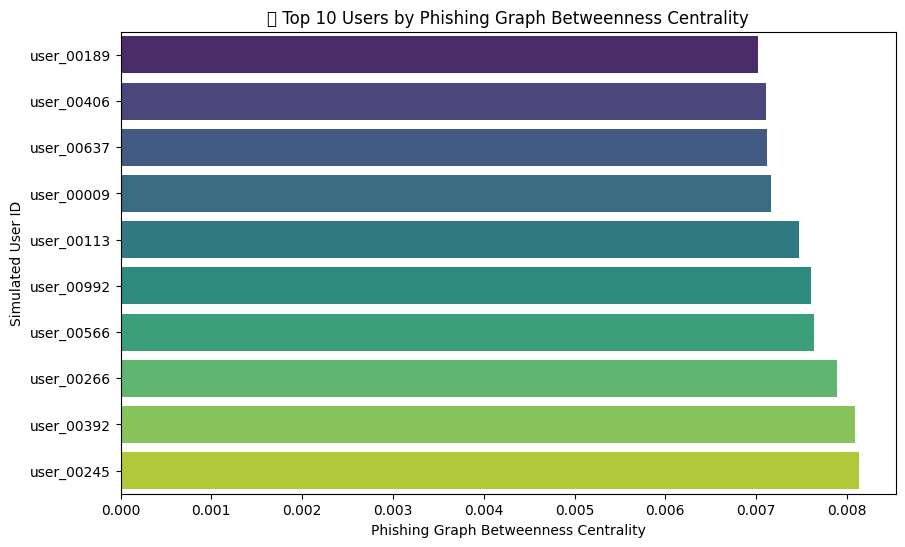


Phishing graph has 1000 nodes. Skipping plot as it exceeds the threshold of 100.


In [ ]:
# %% [markdown]
# ## Graph based feature extraction
# %%
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Import numpy for random sampling
import random # Import random for sampling

# Determine the number of users you want to simulate
NUM_SIMULATED_USERS = 1000 # You can adjust this number

# Create a pool of unique user IDs
user_pool = [f'user_{i+1:05d}' for i in range(NUM_SIMULATED_USERS)]

# --- Assign sender and receiver IDs RANDOMLY for each email ---
# This will create a more diverse set of connections
num_emails = len(df)
# Sample with replacement is fine, as users can send/receive multiple emails
df['sender'] = random.choices(user_pool, k=num_emails)
df['receiver'] = random.choices(user_pool, k=num_emails)


# --- FOCUS ON PHISHING EMAILS FOR GRAPH CONSTRUCTION ---

# Filter the DataFrame to include only phishing emails (Label == 1)
df_phishing = df[df['Label'] == 1].copy() # Use .copy() to avoid SettingWithCopyWarning

# --- Debugging: Check Phishing DataFrame and Sample Edges ---
print(f"\nNumber of phishing emails: {len(df_phishing)}")
if len(df_phishing) > 0:
    print("Sample phishing email sender/receiver pairs:")
    # Sample randomly from the phishing pairs if the DataFrame is large
    print(df_phishing[['sender', 'receiver']].sample(min(5, len(df_phishing))))
else:
    print("No phishing emails found in the dataset.")
# --- End Debugging ---


# Build a directed graph using *only* the sender-receiver pairs from phishing emails
G_phishing = nx.from_pandas_edgelist(df_phishing, source='sender', target='receiver', create_using=nx.DiGraph())

print(f"\nCreated a graph from phishing emails with {G_phishing.number_of_nodes()} nodes and {G_phishing.number_of_edges()} edges.")


# Compute graph metrics on the PHISHING graph
phishing_in_degree = {}
phishing_out_degree = {}
phishing_pagerank = {}
phishing_betweenness = {}

if G_phishing.number_of_nodes() > 0:
    try:
        phishing_in_degree = dict(G_phishing.in_degree())
        phishing_out_degree = dict(G_phishing.out_degree())
        phishing_pagerank = nx.pagerank(G_phishing)
        # Betweenness centrality can be computationally expensive for large graphs.
        # Add a check or consider sampling nodes if G_phishing becomes very large.
        # For performance, use k to specify a sample size if needed:
        # phishing_betweenness = nx.betweenness_centrality(G_phishing, normalized=True, k=min(100, G_phishing.number_of_nodes()))
        phishing_betweenness = nx.betweenness_centrality(G_phishing, normalized=True) # Compute Betweenness Centrality

        # --- Debugging: Check calculated betweenness ---
        print("\nSample Phishing Graph Betweenness Centrality (first 10):")
        # Get a list of (node, betweenness) tuples and print the first few
        sample_betweenness = list(phishing_betweenness.items())[:10]
        for node, bc in sample_betweenness:
            print(f"  {node}: {bc:.6f}")
        # --- End Debugging ---

    except Exception as e:
        print(f"Error computing graph metrics on phishing graph: {e}")
else:
    print("Phishing graph is empty, skipping metric calculation.")


# Add metrics from the PHISHING graph back to the ORIGINAL DataFrame
# We need to map the metrics based on the sender/receiver IDs derived earlier.
# For each email in the original DataFrame, look up the metrics for its simulated sender/receiver
# from the phishing graph. If a user didn't participate in a phishing email interaction
# (i.e., they are not a node in G_phishing), their metric will be 0.
# Note: When using random sampling for sender/receiver, it's highly likely not all 1000 users
# will appear in G_phishing if len(df_phishing) is significantly less than 1000,
# or even if it's larger but many pairs are duplicates.

df['sender_phishing_in_degree'] = df['sender'].apply(lambda x: phishing_in_degree.get(x, 0)).fillna(0)
df['sender_phishing_out_degree'] = df['sender'].apply(lambda x: phishing_out_degree.get(x, 0)).fillna(0)
df['sender_phishing_pagerank'] = df['sender'].apply(lambda x: phishing_pagerank.get(x, 0)).fillna(0)
df['sender_phishing_betweenness'] = df['sender'].apply(lambda x: phishing_betweenness.get(x, 0)).fillna(0)

df['receiver_phishing_in_degree'] = df['receiver'].apply(lambda x: phishing_in_degree.get(x, 0)).fillna(0)
df['receiver_phishing_out_degree'] = df['receiver'].apply(lambda x: phishing_out_degree.get(x, 0)).fillna(0)
df['receiver_phishing_pagerank'] = df['receiver'].apply(lambda x: phishing_pagerank.get(x, 0)).fillna(0)
df['receiver_phishing_betweenness'] = df['receiver'].apply(lambda x: phishing_betweenness.get(x, 0)).fillna(0)


# Display the first few rows with new PHISHING graph features
print("\nDataFrame with Phishing Graph Features:")
print(df[['sender', 'receiver', 'Label', 'sender_phishing_betweenness', 'receiver_phishing_betweenness']].head())


# --- Identify and potentially visualize users with high betweenness in the PHISHING graph ---

print("\nSimulated Users with Highest Phishing Graph Betweenness Centrality:")
sorted_betweenness = [] # Initialize list
if phishing_betweenness:
    # Sort users by betweenness centrality in descending order
    sorted_betweenness = sorted(phishing_betweenness.items(), key=lambda item: item[1], reverse=True)

    # Print the top N users (e.g., top 10)
    top_n_print = 10
    if top_n_print > len(sorted_betweenness):
        top_n_print = len(sorted_betweenness) # Adjust if fewer users than top_n
    for user, score in sorted_betweenness[:top_n_print]:
        print(f"  {user}: {score:.6f}")
else:
    print("  No betweenness centrality data available.")


# === Visualize Top Users by Phishing Graph Betweenness Centrality ===
TOP_N_VIZ = 10 # Number of top users to visualize in the bar chart

if sorted_betweenness: # Only plot if betweenness was calculated and sorted
    # Get the top N users and their scores
    top_users = [user for user, score in sorted_betweenness[:TOP_N_VIZ]]
    top_scores = [score for user, score in sorted_betweenness[:TOP_N_VIZ]]

    if top_users: # Ensure there are users to plot
         plt.figure(figsize=(10, 6))
         # Reverse lists to plot highest score at the top of the bar chart
         sns.barplot(x=top_scores[::-1], y=top_users[::-1], palette="viridis")
         plt.xlabel("Phishing Graph Betweenness Centrality")
         plt.ylabel("Simulated User ID")
         plt.title(f"📊 Top {TOP_N_VIZ} Users by Phishing Graph Betweenness Centrality")
         plt.show()
    else:
         print("No top users identified for plotting.")
else:
    print("No betweenness centrality data available for plotting top users.")


# 🎨 Plot the PHISHING graph with metrics (Conditional Plotting and Highlighting)
# Plotting the phishing graph might be more manageable as it only includes
# nodes and edges involved in phishing interactions.

# You can adjust this threshold or remove it if you want to always attempt plotting
PLOT_PHISHING_GRAPH_THRESHOLD = 100 # Plot if the number of nodes in phishing graph is <= 100
TOP_N_HIGHLIGHT = 5 # Number of top users to highlight ON THE GRAPH PLOT

if G_phishing.number_of_nodes() > 0 and G_phishing.number_of_nodes() <= PLOT_PHISHING_GRAPH_THRESHOLD:
    fig, ax = plt.subplots(figsize=(12, 8)) # Create a figure and axes object
    pos = nx.spring_layout(G_phishing, seed=42) # Use spring layout

    plot_nodes = list(G_phishing.nodes())

    # Ensure metrics dictionaries are populated and nodes exist
    if phishing_pagerank and phishing_betweenness and plot_nodes:
        plot_node_sizes = [phishing_pagerank.get(node, 0) * 5000 for node in plot_nodes] # Adjust multiplier for visibility
        plot_node_colors = [phishing_betweenness.get(node, 0) for node in plot_nodes]

        # --- Highlighting Logic ---
        # Use the already sorted_betweenness to get the top users
        top_betweenness_users = [user for user, score in sorted_betweenness[:TOP_N_HIGHLIGHT]]
        node_colors_highlighted = []
        node_sizes_highlighted = []
        top_user_positions = {}

        # Assign colors and sizes, identify positions for labels
        for node in plot_nodes:
            # Default color based on betweenness colormap
            color = plt.cm.viridis(phishing_betweenness.get(node, 0))
            size = phishing_pagerank.get(node, 0) * 5000

            if node in top_betweenness_users:
                # Assign a distinct color (e.g., red) for top users
                color = 'red'
                # Optionally increase size slightly for top users
                size += 500 # Add a fixed offset to make them slightly bigger
                top_user_positions[node] = pos[node] # Store position for potential labeling

            node_colors_highlighted.append(color)
            node_sizes_highlighted.append(size)

        # --- Drawing the graph with highlighting ---
        node_collection = nx.draw_networkx_nodes(G_phishing, pos, node_size=node_sizes_highlighted, node_color=node_colors_highlighted, ax=ax)
        nx.draw_networkx_edges(G_phishing, pos, arrowstyle='->', arrowsize=15, edge_color='gray', alpha=0.6, ax=ax)

        # Draw labels ONLY for the top N highlighted users (if number is manageable)
        if len(top_betweenness_users) <= 15 and top_user_positions: # Adjust label limit
             nx.draw_networkx_labels(G_phishing, top_user_positions, labels=dict.fromkeys(top_user_positions, None), font_size=8, font_color='black', ax=ax) # Plot labels for top users

        # Color bar for betweenness (still based on the full range)
        # Only add color bar if there's variation in betweenness
        all_betweenness_values = list(phishing_betweenness.values())
        if all_betweenness_values and (max(all_betweenness_values) - min(all_betweenness_values) > 1e-6):
            # Create a scalar mappable from the original colormap and data range
            sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(all_betweenness_values), vmax=max(all_betweenness_values)))
            sm.set_array([]) # Empty array is fine
            cbar = fig.colorbar(sm, ax=ax)
            cbar.set_label("Phishing Graph Betweenness Centrality")
        else:
             print("Skipping color bar: Phishing betweenness centrality values are all the same or empty.")


        plt.title(f"📧 Simulated Phishing Communication Graph\n(Top {TOP_N_HIGHLIGHT} users by Betweenness Highlighted in Red)")
        plt.axis('off')
        plt.show()
    else:
         print("Skipping phishing graph plot: Metrics not available or graph has no nodes for plotting.")
elif G_phishing.number_of_nodes() > PLOT_PHISHING_GRAPH_THRESHOLD:
    print(f"\nPhishing graph has {G_phishing.number_of_nodes()} nodes. Skipping plot as it exceeds the threshold of {PLOT_PHISHING_GRAPH_THRESHOLD}.")
else:
     print("\nPhishing graph is empty, skipping plot.")





🔝 Top 20 Keywords in Phishing Emails (by Average TF-IDF):
email          0.035948
com            0.035900
http           0.033583
click          0.032733
free           0.030390
url            0.022112
new            0.021496
www            0.021148
money          0.020584
online         0.020558
just           0.020163
time           0.019966
information    0.019895
software       0.019208
company        0.019071
business       0.019062
best           0.019031
want           0.018760
list           0.018344
like           0.017876
dtype: float64


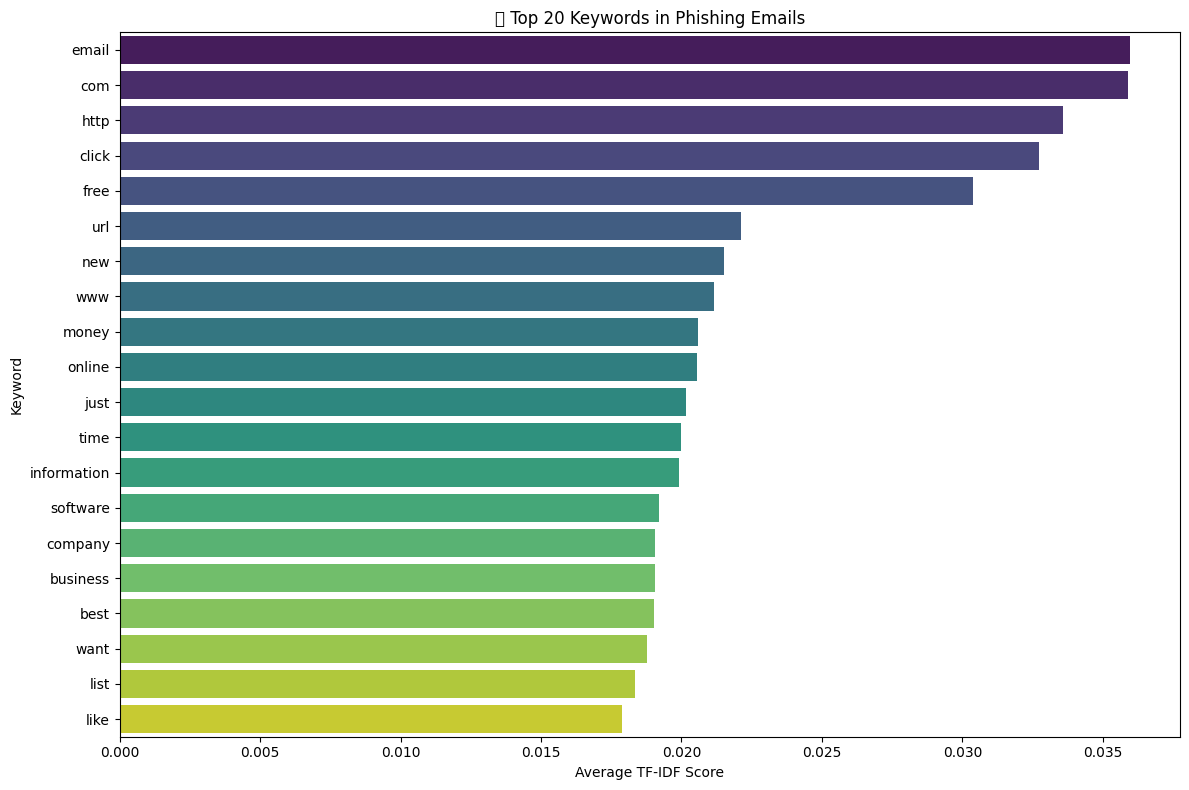


Keyword extraction complete.


In [ ]:
# %% [markdown]
# ## Keyword Extraction from Phishing Emails
# %%
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' and 'clean_text' column are already available from previous steps
# Assuming 'Label' column is also available and '1' indicates phishing

# Filter the DataFrame to include only phishing emails
df_phishing_text = df[df['Label'] == 1].copy()

# Check if there are any phishing emails to process
if len(df_phishing_text) == 0:
    print("⚠️ No phishing emails found in the dataset for keyword extraction.")
else:
    # Initialize TfidfVectorizer
    # max_features: Consider only the top N most frequent terms
    # stop_words: Remove common English stop words
    tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

    # Fit the vectorizer to the cleaned text of phishing emails and transform it
    # This builds the vocabulary and computes TF-IDF scores for each term in each phishing email
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_phishing_text['clean_text'])

    # Get the feature names (the words)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Compute the average TF-IDF score for each word across all phishing emails
    # You can also sum the scores or look at overall term frequency
    avg_tfidf_scores = tfidf_matrix.mean(axis=0).A1 # Convert to a flat numpy array

    # Create a Series to easily associate words with their scores
    word_scores = pd.Series(avg_tfidf_scores, index=feature_names)

    # Sort the words by their average TF-IDF score in descending order
    top_keywords = word_scores.sort_values(ascending=False)

    # Display the top N keywords
    TOP_N_KEYWORDS = 20 # Number of top keywords to display and plot
    print(f"\n🔝 Top {TOP_N_KEYWORDS} Keywords in Phishing Emails (by Average TF-IDF):")
    print(top_keywords.head(TOP_N_KEYWORDS))

    # === Visualize Top Keywords ===
    plt.figure(figsize=(12, 8))
    # Use the head of the sorted Series for plotting
    top_keywords_plot = top_keywords.head(TOP_N_KEYWORDS)
    sns.barplot(x=top_keywords_plot.values, y=top_keywords_plot.index, palette="viridis")
    plt.xlabel("Average TF-IDF Score")
    plt.ylabel("Keyword")
    plt.title(f"📈 Top {TOP_N_KEYWORDS} Keywords in Phishing Emails")
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

print("\nKeyword extraction complete.")